In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from sklearn.datasets import fetch_openml
from scipy.io import loadmat

device = 'cuda' if torch.cuda.is_available() else 'cpu'

plt.style.use('seaborn')
np.__version__, device

('1.21.2', 'cuda')

In [219]:
X_train, X_test = np.load('./Data/MNIST/train_images.npy').reshape(-1, 28, 28),  np.load('./Data/MNIST/test_images.npy').reshape(-1, 28, 28)
y_train, y_test = np.load('./Data/MNIST/train_labels.npy').ravel().astype(np.int32), np.load('./Data/MNIST/test_labels.npy').ravel().astype(np.int32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [228]:
class DigitDataset:
    def __init__(self, X, y, transform=None, for_autoencoder = True):
        self.transform = transform
        self.X = X
        self.y = y
        self.for_autoencoder = for_autoencoder
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.transform(self.X[idx])
        if self.for_autoencoder:
            y = self.transform(self.X[idx]) + torch.rand_like(x)/3
        else:
            y = torch.tensor(self.y[idx]).to(torch.int64)
            
        return x.to(torch.float32), y


train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)

])

batch_size = 512

train_dataset = DigitDataset(X_train, y_train, train_transform)
# val_dataset = DigitDataset(X_val, y_val, val_transform)
test_dataset = DigitDataset(X_test, y_test, val_transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
# val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)



In [229]:
a, b = next(iter(train_loader))
print(a.shape, b.shape)
print(a.dtype, b.dtype)


torch.Size([512, 1, 28, 28]) torch.Size([512, 1, 28, 28])
torch.float32 torch.float32


In [230]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.ModuleList(
            [
                self.create_encoder_block(1, 32), # 32, 14, 14
                self.create_encoder_block(32, 64), # 64, 7, 7
                self.create_encoder_block(64, 128) # 128, 3, 3
            ]
        )
        
        self.decoder = nn.ModuleList(
            [
                self.create_decoder_block(128, 128, kernel_size=4), # 128, 4, 4
                self.create_decoder_block(128, 64, kernel_size=4, stride=1, padding=0), # 64, 7, 7 
                self.create_decoder_block(64, 32, kernel_size=4, padding=1), # 32, 14, 14                
                self.create_decoder_block(32, 1, kernel_size=4, stride=2, padding=1, last=True),  # 3, 28, 28
            ]
        )
        
        self.fc = nn.Linear(128 * 3 * 3, 128 * 1 * 1)
        
    def create_encoder_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding = 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )
        
    def create_decoder_block(self, in_c, out_c, kernel_size=3, padding=0, stride=2, last=False):
        return nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_c),
            nn.ReLU(), 
            
            nn.ConvTranspose2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_c), 
            nn.LeakyReLU(),
            
            nn.Conv2d(out_c, out_c, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU() if last else nn.Sigmoid(),
            
            nn.Dropout(0.2) if last else nn.Identity()
            
        )
        
    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)         # 128, 4, 4

        x = x.view(-1, 128 * 3 * 3)
        x = nn.LeakyReLU()(self.fc(x)) # 128 * 1 * 1
        x = x.view(-1, 128, 1, 1)
        
        for layer in self.decoder:
            x = layer(x)
        
        return x
        

In [231]:
from sklearn.metrics import accuracy_score

class Trainer:
    def __init__(self,
                 model,
                 loss_fxn,
                 train_loader,
                 val_loader,
                 device):
        
        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss_fxn = loss_fxn
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 5e-4)

    def training_step(self, x, y):
        self.model.train()
        y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss, 0

    def val_step(self, x, y):
        with torch.no_grad():
            y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        return loss, 0

    def go_over_batch(self, loader, step_fxn, type):
        loss, acc = 0, 0
        for x, y in tqdm(loader):
            x, y = x.to(self.device), y.to(self.device)
            l, a = step_fxn(x, y)
            loss, acc = loss + l, acc + a
            
        return loss/len(loader), acc/len(loader)

    def train(self, epochs = 13):

        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.go_over_batch(self.train_loader, self.training_step, type='train')
            val_loss, val_acc = self.go_over_batch(self.val_loader, self.val_step, type='val')

            print(f"[Epoch: {epoch}] Train:[loss:{train_loss:.3f} acc:{train_acc:.3f}] Val:[loss:{val_loss:.3f} acc:{val_acc:.3f}]")


In [232]:
trainer = Trainer(
    model = AutoEncoder(),
    train_loader=train_loader,
    val_loader=test_loader,
    loss_fxn=nn.MSELoss(),
    device=device
)

In [233]:
trainer.train()

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.120 acc:0.000] Val:[loss:0.115 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.107 acc:0.000] Val:[loss:0.101 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.088 acc:0.000] Val:[loss:0.085 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.077 acc:0.000] Val:[loss:0.083 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.074 acc:0.000] Val:[loss:0.079 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.071 acc:0.000] Val:[loss:0.076 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.069 acc:0.000] Val:[loss:0.074 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.067 acc:0.000] Val:[loss:0.072 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.066 acc:0.000] Val:[loss:0.070 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.065 acc:0.000] Val:[loss:0.069 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.064 acc:0.000] Val:[loss:0.068 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.062 acc:0.000] Val:[loss:0.066 acc:0.000]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:0.061 acc:0.000] Val:[loss:0.065 acc:0.000]


In [234]:
X_train_denoised = []
X_test_denoised = []

for x, y in tqdm(train_loader):
    with torch.no_grad():
        y_pred = trainer.model(x.to(device)).cpu()
    X_train_denoised.extend(y_pred.numpy().tolist())
    

for x, y in tqdm(test_loader):
    with torch.no_grad():
        y_pred = trainer.model(x.to(device)).cpu()
    X_test_denoised.extend(y_pred.numpy().tolist())
    
    
    

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [235]:
np.array(X_train_denoised).squeeze(1).shape

(60000, 28, 28)

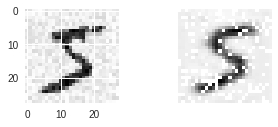

5


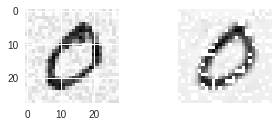

0


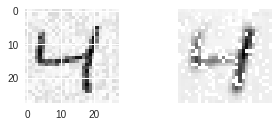

4


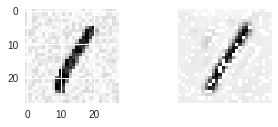

1


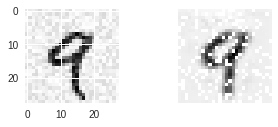

9


In [236]:
a, b = next(iter(train_loader))
counter = 1


for i in range(5):
    plt.figure(figsize=(5, 10))
    
    plt.subplot(5, 2, counter)
    plt.imshow(b[i][0])
    
    plt.subplot(5, 2, counter + 1)
    plt.imshow(X_train_denoised[i][0])
    
    plt.axis('off')
    plt.show()
    
    print(y_train[i])
    
    counter += 2


In [237]:
class Model(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        
        self.layer1 = self.get_layers(1, 32)
        self.layer2 = self.get_layers(32, 64)
        self.layer3 = self.get_layers(64, 128)

        self.drop = nn.Dropout(0.2) if self.params['use_dropout'] else nn.Identity()
        self.fc1 = nn.Linear(128 * 3 * 3, 128 * 1 * 1)
        self.fc2 = nn.Linear(128, 10)

    def get_layers(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=self.params['kernel_size'], stride = 1, padding=self.params['padding']),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        # 1, 28, 28
        x = self.layer1(x) # 32, 14, 14
        x = self.layer2(x) # 64, 7, 7
        x = self.drop(x)
        x = self.layer3(x) # 128, 3, 3

        x = x.view(-1, 128 * 3 * 3) # 128 * 3 * 3

        x = self.drop(x)

        x = nn.ReLU()(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x



In [238]:

from sklearn.metrics import accuracy_score

class Trainer:
    def __init__(self,
                 model,
                 loss_fxn,
                 train_loader,
                 val_loader,
                 device,
                 params,
                 logger):

        self.device = device
        self.params = params
        self.logger = logger
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss_fxn = loss_fxn
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.params['lr'])

    def training_step(self, x, y):
        y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        acc = accuracy_score(y.detach().cpu(), torch.argmax(y_pred, axis=-1).detach().cpu())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        acc = accuracy_score(y.detach().cpu(), torch.argmax(y_pred, axis=-1).detach().cpu())
        return loss, acc

    def go_over_batch(self, loader, step_fxn):
        loss, acc = 0, 0
        for x, y in tqdm(loader):
            x, y = x.to(self.device), y.to(self.device)
            l, a = step_fxn(x, y)
            loss, acc = loss + l, acc + a
            
        return loss/len(loader), acc/len(loader)

    def train(self):

        for epoch in tqdm(range(self.params['epoch'])):
            train_loss, train_acc = self.go_over_batch(self.train_loader, self.training_step)
            val_loss, val_acc = self.go_over_batch(self.val_loader, self.val_step)

            print(f"[Epoch: {epoch}] Train:[loss:{train_loss:.3f} acc:{train_acc:.3f}] Val:[loss:{val_loss:.3f} acc:{val_acc:.3f}]")
            
            if self.logger:
                self.logger.log({'train_loss': train_loss, 'train_acc': train_acc, 
                                'val_loss':val_loss, 'val_acc':val_acc})
        if self.logger:     
            self.logger.finish()

In [239]:
batch_size = 512

train_dataset_denoised = DigitDataset(np.array(X_train_denoised).squeeze(1), y_train, train_transform, for_autoencoder=False)
test_dataset_denoised = DigitDataset(np.array(X_test_denoised).squeeze(1), y_test, val_transform, for_autoencoder=False)

train_loader_denoised = DataLoader(train_dataset_denoised, batch_size = batch_size, shuffle = False)
test_loader_denoised = DataLoader(test_dataset_denoised, batch_size = batch_size, shuffle = False)


In [240]:
a, b = next(iter(train_loader_denoised))

a.shape, b.shape

(torch.Size([512, 1, 28, 28]), torch.Size([512]))

In [241]:
params = {
    'lr' : 1e-4,
    'batch_size': 128,
    'epoch': 10, 
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1
}

trainer = Trainer(
    model = Model(params),
    loss_fxn=nn.CrossEntropyLoss(),
    train_loader=train_loader_denoised,
    val_loader=test_loader_denoised,
    device = device,
    params = params,
    logger = None
)

trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:1.824 acc:0.441] Val:[loss:0.921 acc:0.717]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.680 acc:0.788] Val:[loss:0.514 acc:0.843]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.453 acc:0.861] Val:[loss:0.390 acc:0.879]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.356 acc:0.891] Val:[loss:0.329 acc:0.899]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.305 acc:0.907] Val:[loss:0.289 acc:0.911]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.270 acc:0.918] Val:[loss:0.264 acc:0.920]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.246 acc:0.925] Val:[loss:0.248 acc:0.926]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.229 acc:0.930] Val:[loss:0.232 acc:0.930]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.216 acc:0.934] Val:[loss:0.217 acc:0.935]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.206 acc:0.937] Val:[loss:0.213 acc:0.931]


In [260]:
from sklearn.metrics import classification_report

def test_model(model, loader):
    y_pred, y_true = [], []
    for x, y in tqdm(loader):
        x = x.to(device)
        pred = model(x)
        y_pred.extend(np.argmax(pred.detach().cpu().numpy(), axis=-1))
        y_true.extend(y.numpy())
        
    print(classification_report(y_true, y_pred))

In [261]:
test_model(trainer.model, test_loader_denoised)

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.92      0.93      1032
           3       0.92      0.92      0.92      1010
           4       0.93      0.94      0.93       982
           5       0.91      0.94      0.92       892
           6       0.96      0.96      0.96       958
           7       0.92      0.94      0.93      1028
           8       0.92      0.86      0.89       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## Analysis

Intrestingly, the accuracy after training the CNN classification model on noisy data and denoised data using an Autoencoder are both comparable. 
This is probably because as of now, noise levels injected in the images are kept at a lower value, otherwise the Autoencoder doesn't perform well 
and is not able to denoise the images. Because of this, the CNN model is already able to classify well on the noisy data itself. The Autoencoder
limited by its parameters, denoises somewhat, but then again the CNN model anyhow classifies the data well.